In [38]:
import math
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, quad
from numpy.linalg import inv

class TimeGridError(Exception):
    pass

class UpdateERROR(Exception):
    pass
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Helper Functions
def get_time_grid(t_0,T,tau_size):
    if t_0 == T:
        return np.array([T])
    part_no = np.divide(T-t_0, tau_size)
    tt = np.divide(T-t_0, part_no)
    grid = np.arange(t_0, T+0.00001, tt)
    return grid


def round_nearest(num: float, to: float) -> float:
    return round(num / to) * to

def round_down(num: float, to: float) -> float:
    nearest = round_nearest(num, to)
    if math.isclose(num, nearest): return num
    return nearest if nearest < num else nearest - to

In [3]:
class LQR:
    def __init__(self, H, M, C, D, R, t_0 = 0, T = 1, n=100):
      self.H = H
      self.M = M
      self.C = C
      self.D = D
      self.R = R
      self.t_0 = t_0
      self.T = T
      #helper properties for faster computation
      self.number_of_time_steps = n
      self.tau = np.divide(T - t_0, self.number_of_time_steps)
      self.D_inv = inv(self.D)

    #Helper function
    def change_no_of_time_steps(self,n):
        self.number_of_time_steps = n
        self.tau = np.divide(self.T-self.t_0,n)

    #Helper function
    def update_t_0_and_T(self, t_0,T, n=None):
        self.t_0 = t_0
        self.T = T
        if n is None:
            n = self.number_of_time_steps
        self.change_no_of_time_steps(n)

    def ricatti_ode(self, t, Q, H, M, C, D):
      # using Q' = -S'(T-t)
      Q = Q.reshape(2, 2)
      dq = 2* H.T @ Q - Q @ M @ np.linalg.inv(D) @ M @ Q + C
      return dq.flatten()

    def solve_ricatti_ode(self, time_grid):
      if len(time_grid) == 1:
        return [self.R]
      S_T = self.R.flatten() # initial y_0 must be 1-d
      res = solve_ivp(self.ricatti_ode, (time_grid[0], time_grid[-1]), S_T, t_eval=time_grid, args=(self.H, self.M, self.C, self.D))
      return res.y.T.reshape(-1, 2, 2)[::-1]

    def control_problem_value(self, time_tensor, space_tensor, sigma):
      v = []
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid) #time_tensor[t:] if time tensor if confirmed that it is ordered
        integral = 0
        for s_t in S:
          integral += np.trace(sigma @ sigma.transpose() * s_t) * self.tau# double check with sigma different sizes

        v_values = x @ S[0] @ torch.t(x) + integral
        v.append(v_values.flatten()[0])
      return torch.tensor(v)

    def markov_control(self, time_tensor, space_tensor):
      a = np.zeros(shape=(1, 2))
      for t, x in zip(time_tensor, space_tensor):
        time_grid = get_time_grid(t,self.T, self.tau)
        S = self.solve_ricatti_ode(time_grid)
        a = np.vstack((a,(-self.D_inv @ self.M.transpose() @ S[0] @ x.numpy().transpose()).transpose()))
      return torch.tensor(a[1:])


dim = 2
H = np.identity(dim)
M = np.identity(dim)
C = 0.1 * np.identity(dim)
D = 0.1 * np.identity(dim)
R = np.identity(dim)
sigma = np.array([0.05,0.05])  # 2 rows  d dimensional columns for R-d dim wiener
T = 1.0
t_0 = 0.5

# Example Function Calls
batch_size = 1

time_grid = get_time_grid(t_0,T, 0.01)
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=batch_size)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size,1, 2)))


lqr = LQR(H, M, C, D, R, t_0, T)

# Example Call to helper functions
# lqr.change_no_of_time_steps(10)
# lqr.update_t_0_and_T(0.1,1,25)

#Example call to Class functions
S = lqr.solve_ricatti_ode(time_grid)
v= lqr.control_problem_value(time_tensor, space_tensor, sigma)
a= lqr.markov_control(time_tensor, space_tensor)




Sample Problem with t_0 = 0.5, T=1, x=(3,2)
Value for problem: tensor([3.9367], dtype=torch.float64)
Markov control for problem: tensor([[-9.0792, -6.0528]], dtype=torch.float64)
Plot of S:


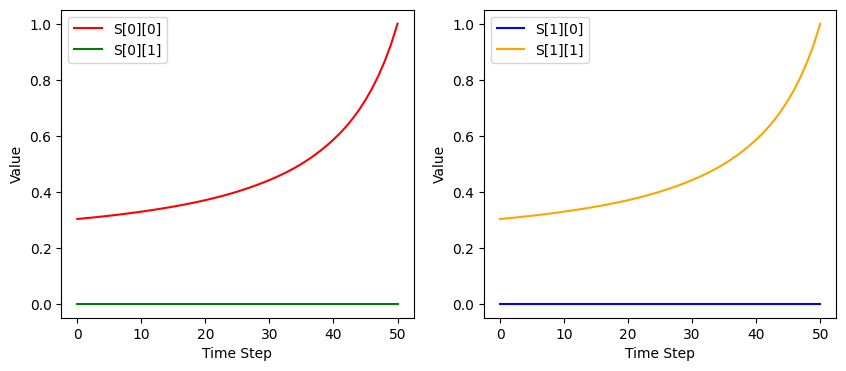

In [4]:
print('Sample Problem with t_0 = 0.5, T=1, x=(3,2)')
print('Value for problem: {}'.format(v))
print('Markov control for problem: {}'.format(a))

print('Plot of S:')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot([s[0][0] for s in S], label='S[0][0]', color='red')
ax[0].plot([s[0][1] for s in S], label='S[0][1]', color='green')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Value')
ax[0].legend()

ax[1].plot([s[1][0] for s in S], label='S[1][0]', color='blue')
ax[1].plot([s[1][1] for s in S], label='S[1][1]', color='orange')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Value')
ax[1].legend()

plt.show()


Exercise 1.2

In [5]:
# 1.2 whole simulation for 8 points including both varying number of steps and batch size takes about an hour to run
def monte_carlo_S_0(lqr_setup, time_tensor_singular):
      time_grid = get_time_grid(time_tensor_singular,lqr_setup.T, lqr_setup.tau)
      S = lqr_setup.solve_ricatti_ode(time_grid)
      return S[0]

def monte_carlo_variable_time_steps(lqr_monte, batch_size, x_np):
    H = torch.tensor(np.copy(lqr_monte.H))
    M = torch.tensor(np.copy(lqr_monte.M))
    D_inv = torch.tensor(np.copy(lqr_monte.D_inv))

    x_t = {}
    a_t = {}
    tau_dict = {}
    for number_of_time_steps in [1, 10, 50, 100, 500, 1000, 5000]:
        lqr_monte.change_no_of_time_steps(number_of_time_steps)
        time_grid_monte_carlo = get_time_grid(lqr_monte.t_0,lqr_monte.T, lqr_monte.tau)
        starting_space_tensor = torch.tensor(np.tile(x_np, batch_size).reshape(batch_size,1,2))
        space_tensor_monte_carlo = starting_space_tensor

        tau_dict[number_of_time_steps] = lqr_monte.tau
        x_t[number_of_time_steps] =[]
        a_t[number_of_time_steps] =[]
        x_t[number_of_time_steps].append(space_tensor_monte_carlo)

        for t_k in time_grid_monte_carlo:
            random_component = torch.randn(batch_size, 1,2) * np.sqrt(lqr_monte.tau) * sigma
            s_t_n = monte_carlo_S_0(lqr_monte, t_k)

            alpha_no_x_t_n = - D_inv @ M.T @ s_t_n
            alpha_control = torch.matmul(alpha_no_x_t_n , space_tensor_monte_carlo.transpose(1, 2)).reshape(batch_size,2)

            x_t_n_coeff = H +(M @ alpha_no_x_t_n)
            X_t_step = lqr_monte.tau*torch.matmul(x_t_n_coeff , space_tensor_monte_carlo.transpose(1, 2)).transpose(1, 2)
            X_t_next_monte_carlo = space_tensor_monte_carlo + X_t_step + random_component

            space_tensor_monte_carlo = X_t_next_monte_carlo
            a_t[number_of_time_steps].append(alpha_control)
            if t_k != time_grid_monte_carlo[-1]:
                x_t[number_of_time_steps].append(X_t_next_monte_carlo)
    return x_t,a_t, tau_dict

def monte_carlo_variable_batch_size(lqr_monte, number_of_time_steps, x_np):
    H = torch.tensor(np.copy(lqr_monte.H))
    M = torch.tensor(np.copy(lqr_monte.M))
    D_inv = torch.tensor(np.copy(lqr_monte.D_inv))

    lqr_monte.change_no_of_time_steps(number_of_time_steps)

    x_t = {}
    a_t = {}
    tau_dict = {}
    time_grid_monte_carlo = get_time_grid(lqr_monte.t_0,lqr_monte.T, lqr_monte.tau)

    for sample_size in [10,50,100,500,1000, 5000, 10000, 50000]:
        x_t[sample_size] =[]
        a_t[sample_size] =[]
        tau_dict[sample_size] = lqr_monte.tau

    for batch_step in [10,50,100,500,1000, 5000, 10000, 50000,100000]:
        starting_space_tensor = torch.tensor(np.tile(x_np, batch_step).reshape(batch_step,1,2))
        space_tensor_monte_carlo = starting_space_tensor

        tau_dict[batch_step] = lqr_monte.tau
        x_t[batch_step] =[]
        a_t[batch_step] =[]
        x_t[batch_step].append(space_tensor_monte_carlo)

        for t_k in time_grid_monte_carlo:
            random_component = torch.randn(batch_step, 1,2) * np.sqrt(lqr_monte.tau) * sigma
            s_t_n = monte_carlo_S_0(lqr_monte, t_k)
            alpha_no_x_t_n = - D_inv @ M.T @ s_t_n
            alpha_control = torch.matmul(alpha_no_x_t_n , space_tensor_monte_carlo.transpose(1, 2)).reshape(batch_step,2)

            x_t_n_coeff = H +(M @ alpha_no_x_t_n)
            X_t_step = lqr_monte.tau*torch.matmul(x_t_n_coeff , space_tensor_monte_carlo.transpose(1, 2)).transpose(1, 2)
            X_t_next_monte_carlo = space_tensor_monte_carlo + X_t_step + random_component

            space_tensor_monte_carlo = X_t_next_monte_carlo
            a_t[batch_step].append(alpha_control)
            if t_k != time_grid_monte_carlo[-1]:
                x_t[batch_step].append(X_t_next_monte_carlo)

    return x_t,a_t, tau_dict


def compute_expected_J(x_t,a_t, tau_dict, lqr_monte, is_n_variable):
    J = {}
    monte_carlo_J_mean = {}
    theoretical_v_values = {}
    theoretical_alpha_value = {}
    lqr_monte.change_no_of_time_steps(5000)

    for key in x_t:
        J[key] =0
        delta_tau = tau_dict[key]

        x_s_prev, a_s_prev = x_t[key][0], a_t[key][0]
        batch_shape = x_s_prev.shape[0]
        for x_s, a_s in zip(x_t[key][1:], a_t[key][1:]):
            x_C_x_prev = torch.matmul(torch.matmul(x_s_prev, torch.tensor(C)),x_s_prev.transpose(1, 2)).reshape(batch_shape,1)
            a_D_a_prev= (torch.matmul(a_s_prev, torch.tensor(D)) * a_s_prev).sum(axis=1).reshape(batch_shape,1)

            x_C_x = torch.matmul(torch.matmul(x_s, torch.tensor(C)),x_s.transpose(1, 2)).reshape(batch_shape,1)
            a_D_a= (torch.matmul(a_s, torch.tensor(D)) * a_s).sum(axis=1).reshape(batch_shape,1)

            J[key] += 0.5*(x_C_x + a_D_a + x_C_x_prev + a_D_a_prev) * delta_tau
            x_s_prev, a_s_prev = x_s.detach().clone(), a_s.detach().clone()

        x_T = x_t[key][-1]
        J[key] += torch.matmul(torch.matmul(x_T, torch.tensor(R)),x_T.transpose(1, 2)).reshape(batch_shape,1)

        monte_carlo_J_mean[key] = torch.mean(J[key]).item()

        if is_n_variable:
            lqr_monte.change_no_of_time_steps(key)
        t_tensor = torch.tensor(np.array(lqr_monte.t_0)).reshape(1,1)
        s_tensor = x_t[key][0]
        theoretical_v_values[key] = lqr_monte.control_problem_value(t_tensor, s_tensor, sigma).item()
        theoretical_alpha_value[key] = lqr_monte.markov_control(t_tensor, s_tensor)

    err=[]
    for key in monte_carlo_J_mean:
        err.append(np.abs(monte_carlo_J_mean[key] - theoretical_v_values[key]))
    return monte_carlo_J_mean,theoretical_v_values,err

def simulate(sim):
    print('Running Simulation {}'.format(sim))
    n_step_sim ={'monte_carlo_J_mean':[],'theoretical_v_values':[],'err':[]}
    n_batch_sim ={'monte_carlo_J_mean':[],'theoretical_v_values':[],'err':[]}
    x_t_n_steps,a_t_n_steps, tau_dict_n_steps = monte_carlo_variable_time_steps(lqr_monte, batch_size=100000, x_np=sim)
    monte_carlo_J_mean,theoretical_v_values,err = compute_expected_J(x_t_n_steps,a_t_n_steps,  tau_dict_n_steps, lqr_monte, True)
    n_step_sim['monte_carlo_J_mean'].append(monte_carlo_J_mean)
    n_step_sim['theoretical_v_values'].append(theoretical_v_values)
    n_step_sim['err'].append(err)

    x_t_batch,a_t_batch, tau_dict_batch = monte_carlo_variable_batch_size(lqr_monte, number_of_time_steps=5000, x_np=sim)
    monte_carlo_J_mean,theoretical_v_values,err = compute_expected_J(x_t_batch,a_t_batch,  tau_dict_batch, lqr_monte, False)
    n_batch_sim['monte_carlo_J_mean'].append(monte_carlo_J_mean)
    n_batch_sim['theoretical_v_values'].append(theoretical_v_values)
    n_batch_sim['err'].append(err)
    return n_step_sim['err'], [key for key in  n_step_sim['theoretical_v_values']], n_batch_sim['err'], [key for key in  n_batch_sim['theoretical_v_values']]

lqr_monte = LQR(H, M, C, D, R,  0, 1)
err_1_list = []
err_2_list = []
key_1_list = []
key_2_list = []

sim_x_values = [np.array((3.0,2.0)),np.array((0.0,1.2)),np.array((1.8,2.2)),np.array((0.9,-2.0)),np.array((-0.5,-1.5)),np.array((3.0,3.0)),np.array((-3.0,-3.0)),np.array((1.0,1.0))]
for sim in sim_x_values:
    err_1, key_1, err_2, key_2 = simulate(sim)
    err_1_list.append(err_1)
    err_2_list.append(err_2)
    key_1_list.append(key_1)
    key_2_list.append(key_2)


Running Simulation [3. 2.]
Running Simulation [0.  1.2]
Running Simulation [1.8 2.2]
Running Simulation [ 0.9 -2. ]
Running Simulation [-0.5 -1.5]
Running Simulation [3. 3.]
Running Simulation [-3. -3.]
Running Simulation [1. 1.]


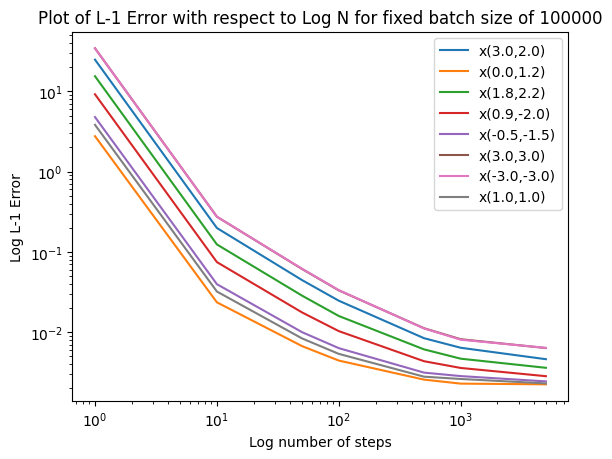

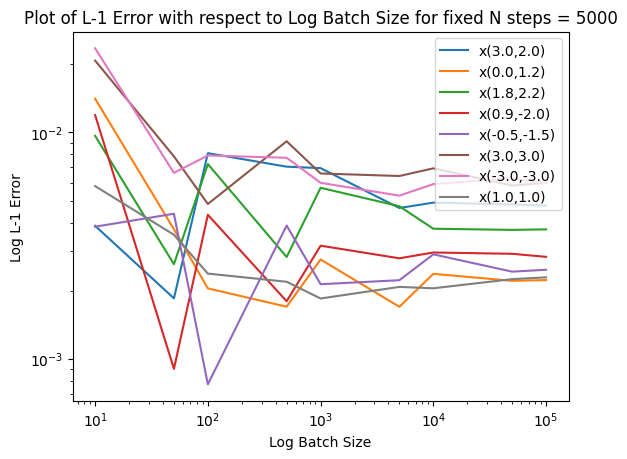

In [6]:
for simulation,error,sim_x in zip(key_1_list,err_1_list,sim_x_values):
    plt.loglog([k for k in simulation[0]], [x for x in error[0]], label='x({},{})'.format(sim_x[0],sim_x[1]))
plt.ylabel('Log L-1 Error')
plt.xlabel('Log number of steps')
plt.legend()
plt.title('Plot of L-1 Error with respect to Log N for fixed batch size of 100000')
plt.show()

for simulation,error,sim_x in zip(key_2_list,err_2_list,sim_x_values):
    plt.loglog([k for k in simulation[0]], [x for x in error[0]],label='x({},{})'.format(sim_x[0],sim_x[1]))
plt.ylabel('Log L-1 Error')
plt.xlabel('Log Batch Size')
plt.title('Plot of L-1 Error with respect to Log Batch Size for fixed N steps = 5000')
plt.legend()
plt.show()


Exercise 2

In [5]:
class DGM_Layer(nn.Module):
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()

        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))


        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)

    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l

    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)

        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)

        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation).to(torch.float64)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation).to(torch.float64)

        self.output_layer = nn.Linear(dim_S, 1).to(torch.float64)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [6]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()

        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).to(torch.float64))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers).to(torch.float64)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x).to(torch.float64)


In [7]:
# 2.1 Setup
t_0 = 0
T = 1
batch_size = 256

time_tensor_dim = 1
space_tensor_dim = 1 * 2

dmg_hidden_layer_size = 100
ffm_hidden_layer_size = 100

loss_improvement_limit = 20
max_num_epochs = 1000

# Define the loss function
loss_function = nn.MSELoss()

lqr_2 = LQR(H, M, C, D, R, t_0, T)


In [12]:
# 2.1 Value function - Training takes roughly 8 minutes to train
# Use Exercise 1.1 to generate the value for training data
lqr_2.update_t_0_and_T(t_0=t_0,T=T,n=100)

# Generate prediction
net_dgm = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)

# Create the optimizer
optimizer = torch.optim.Adam(net_dgm.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0
print('Starting Training Epoch 0 / {}'.format(max_num_epochs))
while train:
    epoch_counter +=1
    if epoch_counter%50 == 0:
        print('Epoch {} / {}'.format(epoch_counter,max_num_epochs))
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)

    y = lqr_2.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)
    y_pred = net_dgm.forward(t_tensor, x_reshaped).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    net_dgm.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False


Starting Training Epoch 0 / 1000
Epoch 50 / 1000
Epoch 100 / 1000
Epoch 150 / 1000
Epoch 200 / 1000
Epoch 250 / 1000
Epoch 300 / 1000
Epoch 350 / 1000
Epoch 400 / 1000
Epoch 450 / 1000
Epoch 500 / 1000
Epoch 550 / 1000
Epoch 600 / 1000
Epoch 650 / 1000
Epoch 700 / 1000
Epoch 750 / 1000
Epoch 800 / 1000
Epoch 850 / 1000
Epoch 900 / 1000
Epoch 950 / 1000
Epoch 1000 / 1000


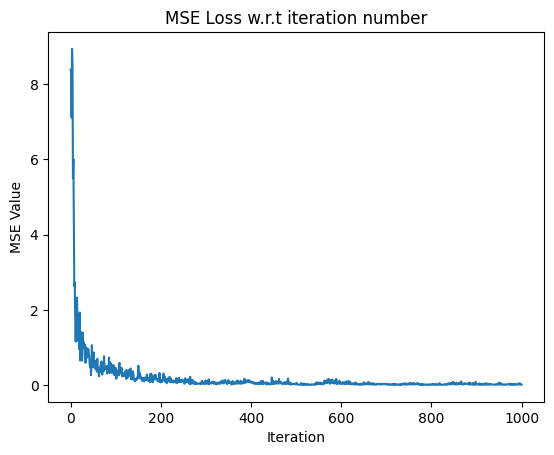

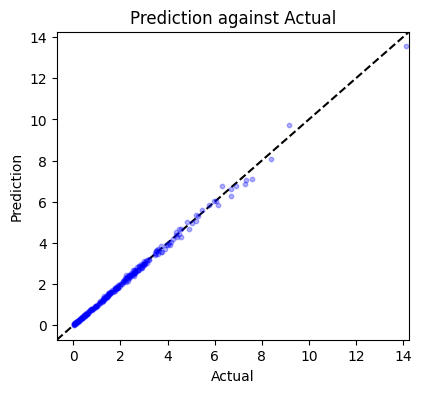

Value Neural Network Training Loss MSE 0.01091044129214527
Validation Loss MSE 0.012548520513217275
Specific Value pred 3.8632689816563786, theoretical value 3.9366972120660604


In [13]:
training_loss_net_dgm = loss
# Plot losses over iteration
plt.plot(losses[1:])
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.title('MSE Loss w.r.t iteration number')
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()

print('Value Neural Network Training Loss MSE {}'.format(training_loss_net_dgm))

# Validation testing
t_tensor_val = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
x_tensor_val = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
x_reshaped_val = x_tensor_val.reshape(-1, 2)

y = lqr_2.control_problem_value(t_tensor_val, x_tensor_val, sigma).unsqueeze(1)
y_pred = net_dgm.forward(t_tensor_val, x_reshaped_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred, y)
print('Validation Loss MSE {}'.format(loss))

# Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y = lqr_2.control_problem_value(time_tensor, space_tensor, sigma).unsqueeze(1)
y_pred = net_dgm.forward(time_tensor, x_reshaped).to(torch.float64)
print('Specific Value pred {}, theoretical value {}'.format(y_pred.item(),y.item()))


Exercise 2.2

In [14]:
#2.2
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
net_ffn_control = FFN(sizes = sizes)
optimizer = torch.optim.Adam(net_ffn_control.parameters(), lr=0.001)

losses = [0]
train = True
loss_no_improvement_counter = 0
epoch_counter = 0
print('Starting Training Epoch 0 / {}'.format(max_num_epochs))
while train:
    epoch_counter +=1
    if epoch_counter%50 == 0:
        print('Epoch {} / {}'.format(epoch_counter,max_num_epochs))
    t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)))
    x_reshaped = x_tensor.reshape(-1, 2)
    input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

    y = lqr_2.markov_control(t_tensor, x_tensor)
    y_pred = net_ffn_control.forward(input_tensor).to(torch.float64)

    # Compute loss
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    net_ffn_control.zero_grad()
    loss.backward()
    optimizer.step()

    if losses[-1] >  losses[-2]:
        loss_no_improvement_counter +=1
        if loss_no_improvement_counter >= loss_improvement_limit:
            train = False
    else:
        loss_no_improvement_counter = 0

    if epoch_counter > max_num_epochs:
        train = False


Starting Training Epoch 0 / 1000
Epoch 50 / 1000
Epoch 100 / 1000
Epoch 150 / 1000
Epoch 200 / 1000
Epoch 250 / 1000
Epoch 300 / 1000
Epoch 350 / 1000
Epoch 400 / 1000
Epoch 450 / 1000
Epoch 500 / 1000
Epoch 550 / 1000
Epoch 600 / 1000
Epoch 650 / 1000
Epoch 700 / 1000
Epoch 750 / 1000
Epoch 800 / 1000
Epoch 850 / 1000
Epoch 900 / 1000
Epoch 950 / 1000
Epoch 1000 / 1000


Control Neural Network Training Loss MSE 0.8149617538132682
Validation Loss MSE 0.5029911338713136
Specific Value pred tensor([-9.7163, -6.3108], dtype=torch.float64, grad_fn=<SelectBackward0>),
Theoretical value tensor([[-9.0792, -6.0528]], dtype=torch.float64)


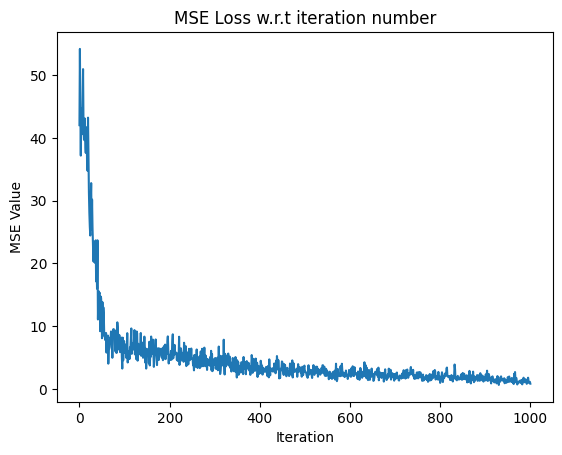

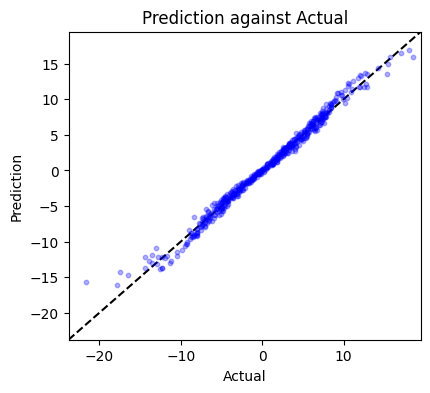

In [15]:
training_loss_net_ffm = loss

losses = losses[1:]
print('Control Neural Network Training Loss MSE {}'.format(training_loss_net_ffm))

y = lqr_2.markov_control(t_tensor_val, x_tensor_val).unsqueeze(1)
input_tensor_val = torch.cat((t_tensor_val, x_reshaped_val), dim=1)
y_pred = net_ffn_control.forward(input_tensor_val).to(torch.float64)
# Compute loss
loss = loss_function(y_pred.reshape(batch_size,2), y.reshape(batch_size,2))
print('Validation Loss MSE {}'.format(loss))


#Specific value testing
time_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=1)).unsqueeze(1)
space_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(1,1, 2)))
x_reshaped = space_tensor.reshape(-1, 2)
input_tensor = torch.cat((time_tensor, x_reshaped), dim=1)
y_s = lqr_2.markov_control(time_tensor, space_tensor).unsqueeze(1)
y_pred_s = net_ffn_control.forward(input_tensor).to(torch.float64)
print('Specific Value pred {},\nTheoretical value {}'.format(y_pred_s[0],y_s[0]))


# Plot losses over iteration
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Value')
plt.title('MSE Loss w.r.t iteration number')
plt.show()

# Plot actual vs prediction
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(y.detach().numpy(), y_pred.detach().numpy(), c='blue', s=10, alpha=0.3)
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
lim = min(x1, y1), min(x2, y2)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, 'k--', zorder=-1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Prediction against Actual')
plt.show()



QUESTION 3



100%|██████████| 1000/1000 [01:52<00:00,  8.10it/s]

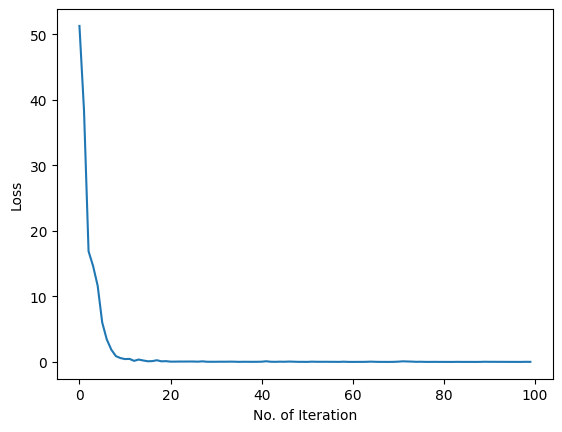

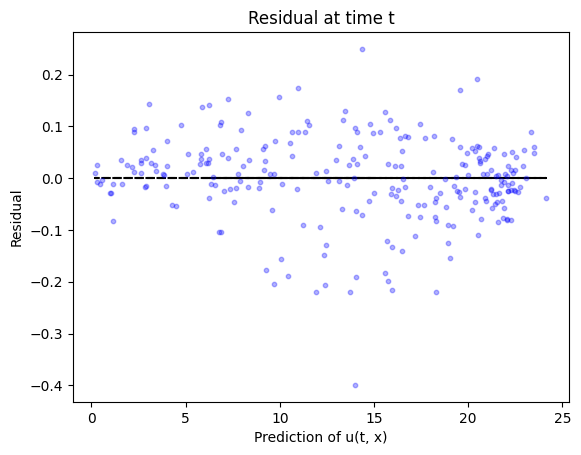

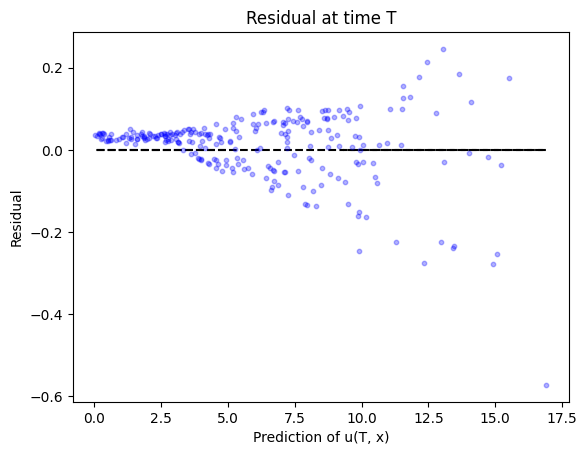

100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


In [40]:
# Training takes about 2 minutes
lqr_3 = LQR(H, M, C, D, R, t_0=0, T=1)

def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hessian(grad, x):
    hessian = torch.zeros(x.shape[0], x.shape [1],x.shape[1])
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad_2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hessian[:,d] = grad_2
    return hessian.to(torch.float64)


class PDE_DGM(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma, alpha=np.array([1.0, 1.0]).T):
        super().__init__()
        self.H = torch.tensor(H)
        self.M = torch.tensor(M)
        self.C = torch.tensor(C)
        self.D = torch.tensor(D)
        self.R = torch.tensor(R)
        self.sigma = torch.tensor(sigma).reshape(2,1)
        self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
        self.alpha = torch.tensor(alpha).reshape(2,1)
        self.M_alpha = self.M @ self.alpha
        self.a_D_a = self.alpha.T @ self.D @ self.alpha
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones = (10000,) ,gamma=0.1)
        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            if iter in [1,10,50,100,500, num_epochs_limit-1]:
                #for plot against monte carlo
                for case in range(len(mc_test_cases)):
                    arr = mc_test_cases[case]
                    test_t_against_monte_carlo = torch.tensor(np.array([float(lqr_3.t_0)]),requires_grad=True).unsqueeze(1)
                    x_tensor_against_monte_carlo = torch.tensor(arr,requires_grad=True).reshape(1,2)
                    training_against_monte_carlo_vals[case].append(self.net_dgm(test_t_against_monte_carlo, x_tensor_against_monte_carlo))

            t_tensor = torch.tensor(np.random.uniform(low=lqr_3.t_0, high=lqr_3.T, size=batch_size),requires_grad=True).unsqueeze(1)#lqr_3.t_0 + lqr_3.T*torch.rand(batch_size, 1, requires_grad=True)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)
            u_of_tx = self.net_dgm(t_tensor, x_tensor)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            M_alpha_grad = torch.matmul(grad_u_x,self.M_alpha)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + self.a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_3.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
            u_of_tx_terminal = self.net_dgm(t_tensor_terminal, x_tensor_terminal)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx_terminal, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)

        if plot:
            # Plot training loss graph
            plt.plot(losses[0::10])
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            # print(losses)

            # Plot loss over equation 1
            plt.scatter(u_of_tx.detach().numpy(), pde.detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx.detach().numpy(), torch.zeros_like(u_of_tx).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('Prediction of u(t, x)')
            plt.ylabel('Residual')
            plt.title('Residual at time t')
            plt.show()

            # Plot loss over equation 2
            plt.scatter(u_of_tx_terminal.detach().numpy(), (u_of_tx_terminal- target_boundary).detach().numpy(), c='blue', s=10, alpha=0.3)
            plt.plot(u_of_tx_terminal.detach().numpy(), torch.zeros_like(u_of_tx_terminal).detach().numpy(), 'k--', zorder=-1)
            plt.xlabel('Prediction of u(T, x)')
            plt.ylabel('Residual')
            plt.title('Residual at time T')
            plt.show()

    def forward(self, t_tensor, x_tensor):
        return self.net_dgm.forward(t_tensor, x_tensor).to(torch.float64)

training_against_monte_carlo_vals = {}
mc_test_cases = [np.array((3.0,2.0)),np.array((0.0,1.2)),np.array((1.8,2.2)),np.array((0.9,-2.0)),np.array((-0.5,-1.5)),np.array((3.0,3.0)),np.array((-3.0,-3.0)),np.array((1.0,1.0))]
for case in range(len(mc_test_cases)):
    training_against_monte_carlo_vals[case] = []


dgm = PDE_DGM(H, M, C, D, R, sigma)
dgm.fit(256, 1000, plot=True)

In [15]:
# testing
def test_3(H, M, C, D, R, sigma):
    batch_size = 1
    H = torch.tensor(H)
    M = torch.tensor(M)
    C = torch.tensor(C)
    D = torch.tensor(D)
    R = torch.tensor(R)
    sigma = torch.tensor(sigma).reshape(2,1)
    sigma_sigma_t = torch.tensor(sigma @ sigma.T)
    alpha = np.array([1.0, 1.0]).T
    alpha = torch.tensor(alpha).reshape(2,1)
    M_alpha = M @ alpha
    a_D_a = alpha.T @ D @ alpha
    t_tensor = torch.tensor(np.random.uniform(low=0.5, high=0.5, size=(batch_size, 1)), requires_grad=True)
    x_tensor = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)), requires_grad=True)
    u_of_tx = dgm.forward(t_tensor, x_tensor)
    grad_u_x = get_gradient(u_of_tx, x_tensor)
    grad_u_t = get_gradient(u_of_tx, t_tensor)
    hessian = get_hessian(grad_u_x, x_tensor)

    trace_sigma_sigma_hessian = torch.matmul(sigma_sigma_t,hessian)
    trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
    H_x_grad = (grad_u_x *  torch.transpose((H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
    M_alpha_grad = torch.matmul(grad_u_x,M_alpha)
    x_C_x = (x_tensor *  torch.transpose((C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

    pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

    t_tensor_terminal = torch.ones(batch_size, 1) * 1
    x_tensor_terminal = torch.tensor(np.random.uniform(low=(3, 2), high=(3, 2), size=(batch_size, 2)))
    u_of_tx_bound = dgm.forward(t_tensor_terminal, x_tensor_terminal)
    target_boundary = (x_tensor_terminal *  torch.transpose((R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size, 1)

    print(f'Equation 1: {pde}, Target: 0')
    print(f'u(T,x): {u_of_tx_bound}, Target: {target_boundary}')

test_3(H, M, C, D, R, sigma)

Equation 1: tensor([[-0.0508]], dtype=torch.float64, grad_fn=<AddBackward0>), Target: 0
u(T,x): tensor([[12.9240]], dtype=torch.float64, grad_fn=<AddmmBackward0>), Target: tensor([[13.]], dtype=torch.float64)


In [16]:
#Monte Carlo simulation with constant alpha
def monte_carlo_variable_time_steps_Q_3_Modification(lqr_monte, batch_size, x_np):
    H = torch.tensor(np.copy(lqr_monte.H))
    M = torch.tensor(np.copy(lqr_monte.M))

    x_t = {}
    a_t = {}
    tau_dict = {}
    for number_of_time_steps in [1, 10, 50, 100, 500, 1000]:
        lqr_monte.change_no_of_time_steps(number_of_time_steps)
        time_grid_monte_carlo = get_time_grid(lqr_monte.t_0,lqr_monte.T, lqr_monte.tau)
        starting_space_tensor = torch.tensor(np.tile(x_np, batch_size).reshape(batch_size,1,2))
        space_tensor_monte_carlo = starting_space_tensor

        tau_dict[number_of_time_steps] = lqr_monte.tau
        x_t[number_of_time_steps] =[]
        a_t[number_of_time_steps] =[]
        x_t[number_of_time_steps].append(space_tensor_monte_carlo)

        for t_k in time_grid_monte_carlo:
            random_component = torch.randn(batch_size, 1,2) * np.sqrt(lqr_monte.tau) * sigma

            alpha_control = torch.tensor(np.array([1.0,1.0])).reshape(2,1)

            # x_t_n_coeff = H +(M @ alpha_no_x_t_n)
            X_t_step = lqr_monte.tau*(torch.matmul(H , space_tensor_monte_carlo.transpose(1, 2)).transpose(1, 2) + torch.tensor(np.tile(M@alpha_control, batch_size).reshape(batch_size,1,2)))
            X_t_next_monte_carlo = space_tensor_monte_carlo + X_t_step + random_component

            space_tensor_monte_carlo = X_t_next_monte_carlo
            a_t[number_of_time_steps].append( torch.tensor(np.tile(alpha_control, batch_size).reshape(batch_size,2)))
            if t_k != time_grid_monte_carlo[-1]:
                x_t[number_of_time_steps].append(X_t_next_monte_carlo)
    return x_t,a_t, tau_dict


monte_sims_q_3 = {}
for case in range(len(mc_test_cases)):
    arr = mc_test_cases[case]
    x_t_q3,a_t_q3, tau_dict_q3 = monte_carlo_variable_time_steps_Q_3_Modification(lqr_3, 256, arr)
    monte_carlo_J_mean_q3,_,_ = compute_expected_J(x_t_q3,a_t_q3, tau_dict_q3, lqr_3, True)
    monte_sims_q_3[case] = (monte_carlo_J_mean_q3)

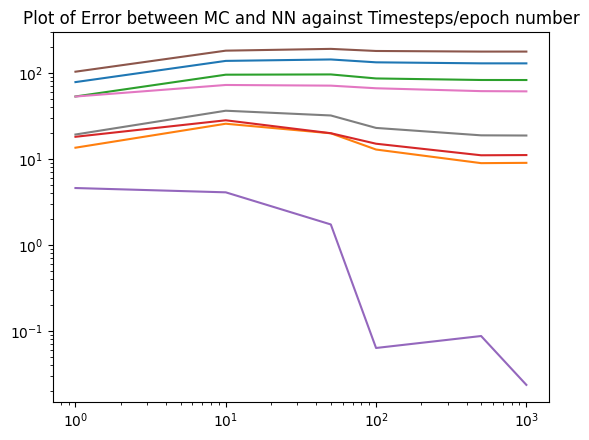

In [17]:
error_lists = []
for case in monte_sims_q_3:
    err_l = []
    mc = monte_sims_q_3[case]
    nn = training_against_monte_carlo_vals[case]
    for m,n in zip(mc,nn):
        err_l.append(abs(mc[m]-n.item()))
    error_lists.append(err_l)

for e_list in error_lists:
    plt.loglog([i for i in monte_sims_q_3[0]], e_list)
plt.title('Plot of Error between MC and NN against Timesteps/epoch number')
plt.show()



Question 4

/var/folders/vb/_758hrnd5kg3rc7nb7tzh46h0000gn/T/ipykernel_81172/2087202014.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)

 60%|██████    | 3000/5000 [49:11<29:38,  1.12it/s]

MSE Loss: 0.0454420986685648


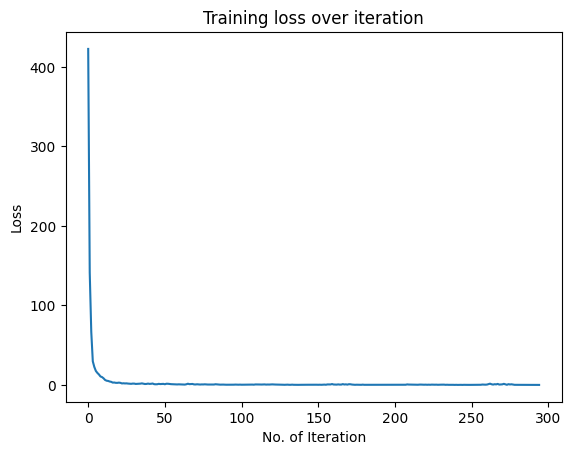

 60%|██████    | 3000/5000 [49:51<33:14,  1.00it/s]


In [31]:
# Modified DGM Model from Q3 which takes alpha also as an input. This model takes roughly 50 mins to train
lqr_q_4 = LQR(H, M, C, D, R, t_0=0, T=1)
class PDE_DGM_modified(torch.nn.Module):
    def __init__(self, H, M, C, D, R, sigma):
        super().__init__()
        self.H = torch.tensor(H)
        self.M = torch.tensor(M)
        self.C = torch.tensor(C)
        self.D = torch.tensor(D)
        self.R = torch.tensor(R)
        self.sigma = torch.tensor(sigma).reshape(2,1)
        self.sigma_sigma_t = torch.tensor(self.sigma @ self.sigma.T)
        self.net_dgm = Net_DGM(time_tensor_dim + space_tensor_dim + 2 - 1, 100, activation='Tanh')

    def fit(self, batch_size, num_epochs_limit, plot=True):
        # Create Adam optimizer
        optimizer = torch.optim.Adam(self.net_dgm.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (10000,), gamma=0.1)

        loss_fn = torch.nn.MSELoss()

        # Train model
        pbar = tqdm.tqdm(total=num_epochs_limit)
        losses = []

        for iter in range(num_epochs_limit):
            t_tensor = torch.tensor(np.random.uniform(low=0, high=1, size=batch_size),requires_grad=True).unsqueeze(1)
            x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)),requires_grad=True)
            alpha_train = lqr_q_4.markov_control(t_tensor.detach().numpy(), x_tensor.detach().reshape(batch_size,1,2))

            u_of_tx = self.forward_mod(t_tensor, x_tensor, alpha_train)
            grad_u_x = get_gradient(u_of_tx, x_tensor)
            grad_u_t = get_gradient(u_of_tx, t_tensor)
            hessian = get_hessian(grad_u_x, x_tensor)
            target_equation = torch.zeros_like(u_of_tx)

            trace_sigma_sigma_hessian = torch.matmul(self.sigma_sigma_t,hessian)
            trace_sigma_sigma_hessian = (0.5 * torch.vmap(torch.trace)(trace_sigma_sigma_hessian)).reshape(batch_size,1)
            H_x_grad = (grad_u_x *  torch.transpose((self.H @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)

            M_alpha_grad = (grad_u_x *  torch.transpose((self.M @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size,1)
            x_C_x = (x_tensor *  torch.transpose((self.C @ x_tensor.T),0,1)).sum(axis=1).reshape(batch_size,1)
            a_D_a = (alpha_train *  torch.transpose((self.D @ alpha_train.T),0,1)).sum(axis=1).reshape(batch_size,1)

            pde = grad_u_t + trace_sigma_sigma_hessian + H_x_grad + M_alpha_grad + x_C_x + a_D_a

            MSE_equation = loss_fn(pde, target_equation)

            # Compute R boundary
            t_tensor_terminal = torch.ones(batch_size, 1) * lqr_q_4.T
            x_tensor_terminal = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
            u_of_tx = self.forward_mod(t_tensor_terminal, x_tensor_terminal,alpha_train)
            target_boundary = (x_tensor_terminal *  torch.transpose((self.R @ x_tensor_terminal.T),0,1)).sum(axis=1).reshape(batch_size,1)
            MSE_boundary = loss_fn(u_of_tx, target_boundary)

            # Store loss values
            loss = MSE_equation + MSE_boundary
            losses.append(loss.item())

            self.net_dgm.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            if iter % 100 == 0:
                pbar.update(100)
            if loss < 0.05:
              break

        if plot:
            # Plot training loss graph
            print('MSE Loss: {}'.format(loss))
            plt.plot(losses[0::10])
            plt.title('Training loss over iteration')
            plt.xlabel('No. of Iteration')
            plt.ylabel('Loss')
            plt.show()
            # print(losses)

    def forward_mod(self, t_tensor, x_tensor, a_tensor):

        return self.net_dgm.forward(t_tensor, torch.cat((x_tensor, a_tensor), dim=1)).to(torch.float64)

dgm_q_4 = PDE_DGM_modified(H, M, C, D, R, sigma)
dgm_q_4.fit(512, 5000, plot=True)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000


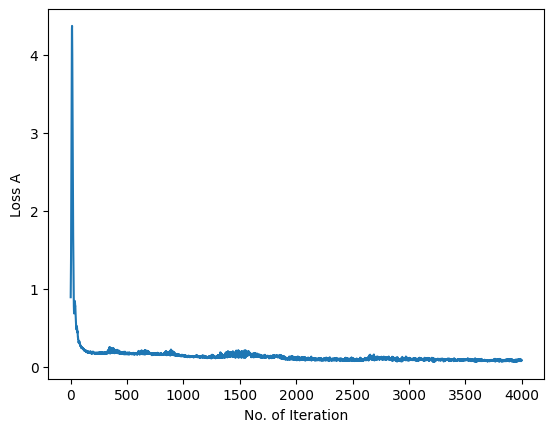

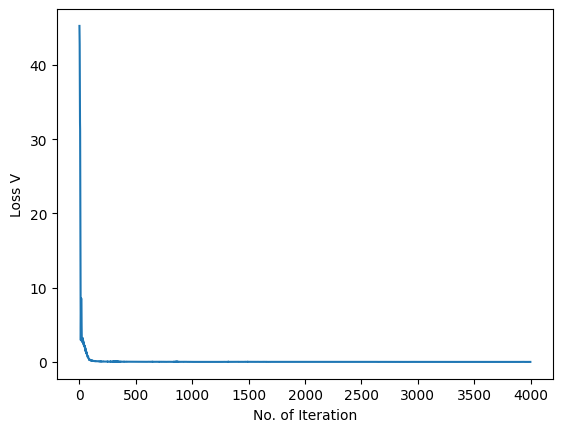

In [32]:
# Question 4 - Policy iteration algorithm
# Pre-defined parameters

# -------
batch_size = 2048
# Fit estimator for a
sizes = [time_tensor_dim + space_tensor_dim, 100, 100, 2]
q_4_a_model = FFN(sizes = sizes)
optimizer_a = torch.optim.Adam(q_4_a_model.parameters(), lr=0.001)

# Generate prediction
q_4_v_model = Net_DGM(dim_x=time_tensor_dim + space_tensor_dim - 1, dim_S=dmg_hidden_layer_size)
optimizer_v = torch.optim.Adam(q_4_v_model.parameters(), lr=0.001)

u_model = dgm_q_4

losses_a = []
losses_v = []
# ------
for i in range(4000):
    if i % 1000 == 0:
        print('Iteration {}'.format(i))
    q_4_t_tensor = torch.tensor(np.random.uniform(low=0, high=T, size=batch_size)).unsqueeze(1)
    q_4_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size,1, 2)),requires_grad=True)
    q_4_x_reshaped = q_4_x_tensor.reshape(-1, 2)
    q_4_input_tensor = torch.cat((q_4_t_tensor, q_4_x_reshaped), dim=1)

    # Approximate a
    q_4_a_pred = q_4_a_model.forward(q_4_input_tensor).to(torch.float64)

    # Generate control for v
    q_4_v_actual = u_model.forward_mod(q_4_t_tensor,q_4_x_reshaped,q_4_a_pred)
    # print(f'v_actual:{v_actual}')

    # Approximate v
    q_4_v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped)
    # print(f'v_approx:{v_approx}')

    # Update theta val
    optimizer_v.zero_grad()
    mse_loss = nn.MSELoss()
    loss_v = mse_loss(q_4_v_approx, q_4_v_actual)
    losses_v.append(loss_v.item())
    loss_v.backward(retain_graph=True)
    optimizer_v.step()

    #ii
    v_approx = q_4_v_model.forward(q_4_t_tensor, q_4_x_reshaped)
    # Approximate v using the trained model
    grad_u_x = torch.autograd.grad(v_approx, q_4_x_reshaped, grad_outputs=torch.ones_like(v_approx), create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Calculate Hamiltonian as loss that we are trying to minimize
    hamiltonian = (grad_u_x *  torch.transpose((torch.tensor(H) @ q_4_x_reshaped.T),0,1)).sum(axis=1).reshape(batch_size,1) + \
                  (grad_u_x *  torch.transpose((torch.tensor(M) @ q_4_a_pred.T),0,1)).sum(axis=1).reshape(batch_size,1) +  \
                  (q_4_x_reshaped *  torch.transpose((torch.tensor(C) @ q_4_x_reshaped.T),0,1)).sum(axis=1).reshape(batch_size,1)+\
                    (q_4_a_pred *  torch.transpose((torch.tensor(D) @ q_4_a_pred.T),0,1)).sum(axis=1).reshape(batch_size,1)

    optimizer_a.zero_grad()
    mae_loss_h = nn.L1Loss()
    loss_a_ham = mae_loss_h(hamiltonian, torch.zeros_like(hamiltonian))
    loss_a_ham.backward(retain_graph=True)
    optimizer_a.step()
    losses_a.append(loss_a_ham.item())

 # Plot training loss graph
plt.plot(losses_a[1:])
plt.xlabel('No. of Iteration')
plt.ylabel('Loss A')
plt.show()

 # Plot training loss graph
plt.plot(losses_v[1:])
plt.xlabel('No. of Iteration')
plt.ylabel('Loss V')
plt.show()


In [36]:
# Compare with 1.1
batch_size = 1
# Sample t uniformly on [0, T]
t_tensor = torch.tensor(np.random.uniform(low=0.0, high=0.0, size=batch_size)).unsqueeze(1)
x_tensor = torch.tensor(np.random.uniform(low=(0.2, 0.4), high=(0.2,0.4), size=(batch_size, 2)))
x_reshaped = x_tensor.reshape(-1, 2)
input_tensor = torch.cat((t_tensor, x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64)
a_actual = lqr_q_4.markov_control(t_tensor, x_tensor)

print(f'MSE of a: {loss_fn(a_pred, a_actual)}')
print('Control actual {} \nControl prediction {}'.format(a_actual[0],a_pred[0]))

# #
# Compare v_pred and v from 1.1
v_pred = q_4_v_model.forward(t_tensor, x_reshaped)
v_actual = lqr_q_4.control_problem_value(t_tensor, x_tensor, sigma).unsqueeze(1)

print(f'MSE of v: {loss_fn(v_pred, v_actual)}')
print('Value actual {} \nValue prediction {}'.format(v_actual[0],v_pred[0]))

MSE of a: 0.019041444706284612
Control actual tensor([-0.5087, -1.0174], dtype=torch.float64) 
Control prediction tensor([-0.5769, -0.8346], dtype=torch.float64, grad_fn=<SelectBackward0>)
MSE of v: 0.018792867749291006
Value actual tensor([0.0546], dtype=torch.float64) 
Value prediction tensor([0.1917], dtype=torch.float64, grad_fn=<SelectBackward0>)


In [35]:
# Compare with 1.1 Batch Values
print('Comparision with Qeustion 1.1 Batch size of 512')
batch_size = 512
# Sample t uniformly on [0, T]
batch_t_tensor = torch.tensor(np.random.uniform(low=0.0, high=0.5, size=batch_size)).unsqueeze(1)
batch_x_tensor = torch.tensor(np.random.uniform(low=(-3, -3), high=(3, 3), size=(batch_size, 2)))
batch_x_reshaped = batch_x_tensor.reshape(-1, 2)
input_tensor = torch.cat((batch_t_tensor, batch_x_reshaped), dim=1)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Compare a_pred and a from 1.1
a_pred = q_4_a_model.forward(input_tensor).to(torch.float64)
a_actual = lqr_q_4.markov_control(batch_t_tensor, batch_x_tensor)
print(f'MSE of actions: {loss_fn(a_pred, a_actual)}')
# #
# # Compare v_pred and v from 1.1
v_pred = q_4_v_model.forward(batch_t_tensor, batch_x_reshaped)
v_actual = lqr.control_problem_value(batch_t_tensor, batch_x_tensor, sigma).unsqueeze(1)
print(f'MSE of value: {loss_fn(v_pred, v_actual)}')

Comparision with Qeustion 1.1 Batch size of 512
MSE of actions: 6.5170373248567115
MSE of value: 2.711917596598035
